# Dimsum Classification

* uses images downloaded from google images
* links curated with gi2ds (Google Image Search to Dataset) by Christoffer Björkskog. [Blog](http://bskog.com/ai/2018/10/30/creating-dataset-google-image-search-results/) and [Github](https://github.com/toffebjorkskog/ml-tools/blob/master/gi2ds.md)

In [0]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *

## Setup, download and verify data

In [0]:
dirs_dimsum = ['hargow', 'siumai', 'charsiusou', 'cheecheongfun','lobakgo']
files_dimsum = ['urls_hargow200.txt', 'urls_siumai200.txt', 
                'urls_charsiusou200.txt', 'urls_cheecheongfun200.txt',
                'urls_lobakgo200.txt']

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = '/content/gdrive/My Drive/'
base_dir = root_dir + 'fastaiv3/'

In [0]:
from shutil import copy2
path = Path('data/dimsum')
for folder, file in list(zip(dirs_dimsum, files_dimsum)):
    dest = path/folder
    dest.mkdir(parents=True, exist_ok=True)
    copy2(base_dir+'dimsum_class/'+file, dest)
    

In [0]:
path.ls()

[PosixPath('data/dimsum/charsiusou'),
 PosixPath('data/dimsum/siumai'),
 PosixPath('data/dimsum/hargow'),
 PosixPath('data/dimsum/lobakgo'),
 PosixPath('data/dimsum/cheecheongfun')]

In [0]:
path = Path('data/dimsum')
for folder, file in list(zip(dirs_dimsum, files_dimsum)):
    download_images(path/folder/file, path/folder, max_pics=200)

In [0]:
classes = dirs_dimsum

In [0]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=200)

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train='.', valid_pct=0.2,
                                  ds_tfms=get_transforms(), size=224,
                                 num_workers=4).normalize(imagenet_stats)

In [0]:
#local setup rerun
path = Path('content/data/dimsum')
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train='.', valid_pct=0.2,
                                  ds_tfms=get_transforms(), size=224,
                                 num_workers=4).normalize(imagenet_stats)

In [0]:
data.classes

['charsiusou', 'cheecheongfun', 'hargow', 'lobakgo', 'siumai']

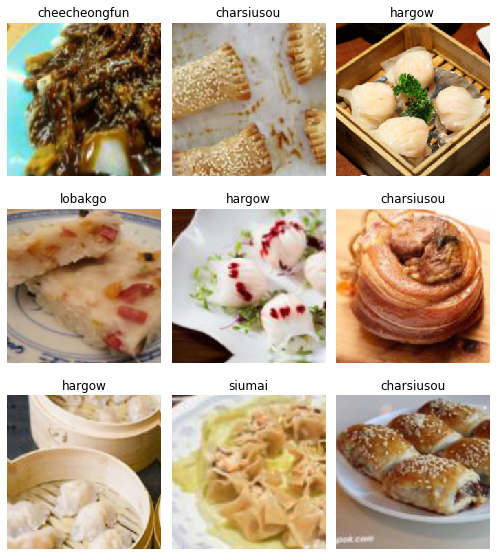

In [0]:
data.show_batch(rows=3, figsize=(7,8))

In [0]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['charsiusou', 'cheecheongfun', 'hargow', 'lobakgo', 'siumai'], 5, 738, 184)

## Model Training with Transfer Learning

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/yoke/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:03<00:00, 24127371.58it/s]


In [0]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.892826,1.363298,0.516304,00:07
1,1.473497,0.831715,0.282609,00:07
2,1.158775,0.728580,0.244565,00:07
3,0.939784,0.627291,0.217391,00:07
4,0.785094,0.622544,0.211957,00:07
5,0.670714,0.568230,0.157609,00:07
6,0.598721,0.547424,0.163043,00:07
7,0.527969,0.552321,0.173913,00:07
8,0.476596,0.549852,0.179348,00:07
9,0.443554,0.550588,0.179348,00:07


In [0]:
learn.save('stage-1')

## Model finetuning

In [0]:
learn.unfreeze()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


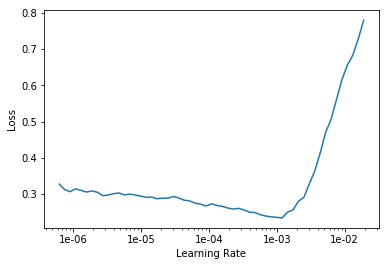

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, max_lr=slice(5e-4, 1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.296187,0.695414,0.211957,00:07
1,0.390351,1.626430,0.309783,00:08
2,0.425384,2.619203,0.429348,00:08
3,0.367741,0.679681,0.168478,00:08
4,0.326681,0.530172,0.146739,00:08


In [0]:
learn.save('stage-2')

In [0]:
interpret = ClassificationInterpretation.from_learner(learn)

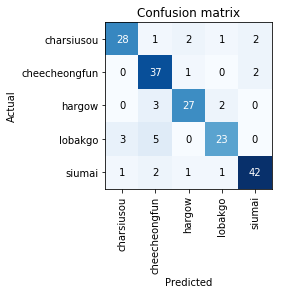

In [0]:
interpret.plot_confusion_matrix()

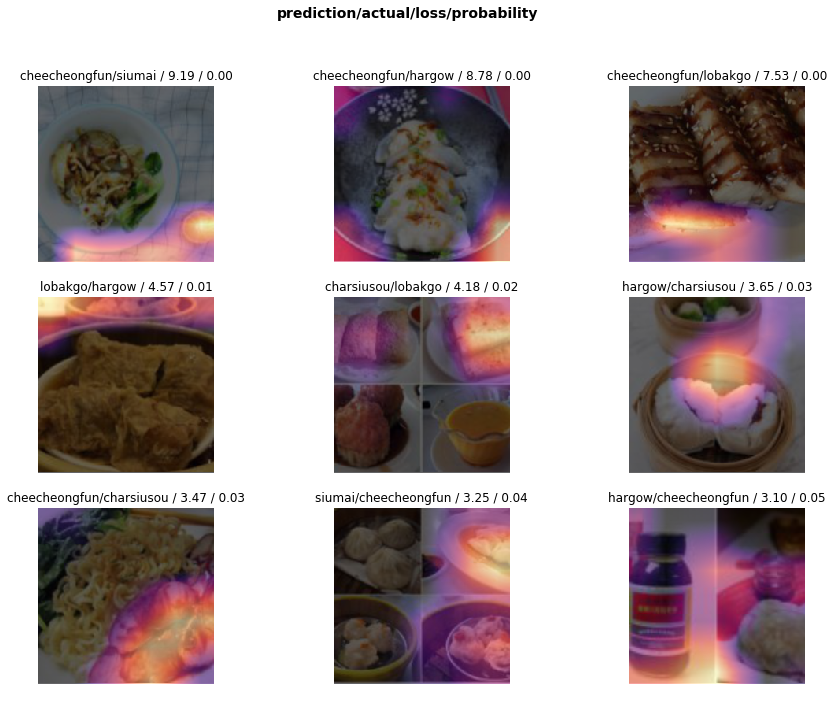

In [0]:
interpret.plot_top_losses(9, figsize=(15,11))

In [0]:
# Google Colab does not support widgets. Need to run in local environment
#from fastai.widgets import *
#ds, idxs = DatasetFormatter().from_toplosses(learn)
#ImageCleaner(ds, idxs, path)

In [0]:
learn.export('stage2.pkl')

In [0]:
!zip -r download_colab.zip /content/data/dimsum

## Run in local runtime for ImageCleaner

* Prunes misleading data and labels

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *

In [0]:
#local setup rerun
path = Path('content/data/dimsum')
np.random.seed(42)
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [0]:
db.show_batch(rows=3, figsize=(7,8))

In [0]:
learn_cleaning = cnn_learner(db, models.resnet34, metrics=error_rate)

In [0]:
learn_cleaning.load('stage-2')

In [0]:
from fastai.widgets import *

In [0]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cleaning) 

DatasetFormatter does not differentiate train/validation set anymore, hence n

In [0]:
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

## Reload and retrain cleaned dataset

- After running on local, upload cleaned.csv, reload and retrain

In [0]:
!mv /content/cleaned.csv /content/data/dimsum

In [0]:
np.random.seed(42)

data2 = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, 
                                csv_labels='cleaned.csv', 
                                ds_tfms=get_transforms(), 
                                size=224, 
                                num_workers=4).normalize(imagenet_stats)

In [0]:
data2.classes, data2.c, len(data2.train_ds), len(data2.valid_ds)

(['charsiusou', 'cheecheongfun', 'hargow', 'lobakgo', 'siumai'], 5, 472, 118)

In [0]:
learn_cleaned = cnn_learner(data2, models.resnet34, metrics=error_rate)

In [0]:
learn_cleaned.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.958007,1.473040,0.644068,00:05
1,1.535733,0.663816,0.161017,00:05
2,1.177153,0.491802,0.152542,00:05
3,0.915417,0.515325,0.152542,00:05
4,0.747979,0.513231,0.169492,00:05
5,0.633824,0.520064,0.169492,00:05
6,0.544484,0.516060,0.169492,00:05
7,0.475155,0.514972,0.169492,00:05
8,0.413666,0.512496,0.169492,00:05
9,0.370536,0.515782,0.169492,00:05


In [0]:
learn_cleaned.unfreeze()

In [0]:
learn_cleaned.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


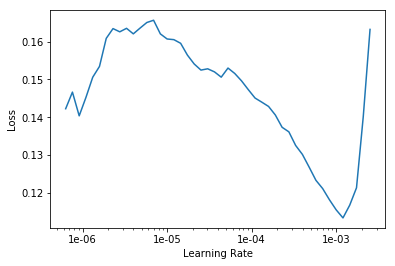

In [0]:
learn_cleaned.recorder.plot()

In [0]:
learn_cleaned.fit_one_cycle(5, max_lr=slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.150190,0.461228,0.169492,00:05
1,0.122265,0.665217,0.177966,00:05
2,0.118568,0.567386,0.152542,00:05
3,0.104063,0.560797,0.127119,00:05
4,0.088834,0.486471,0.127119,00:05


In [0]:
learn_cleaned.save('stage-3')

In [0]:
interpret_cleaned = ClassificationInterpretation.from_learner(learn_cleaned)

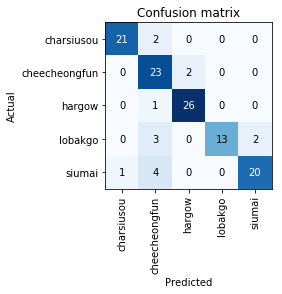

In [0]:
interpret_cleaned.plot_confusion_matrix()

In [0]:
interpret_cleaned.most_confused()

[('siumai', 'cheecheongfun', 4),
 ('lobakgo', 'cheecheongfun', 3),
 ('charsiusou', 'cheecheongfun', 2),
 ('cheecheongfun', 'hargow', 2),
 ('lobakgo', 'siumai', 2),
 ('hargow', 'cheecheongfun', 1),
 ('siumai', 'charsiusou', 1)]

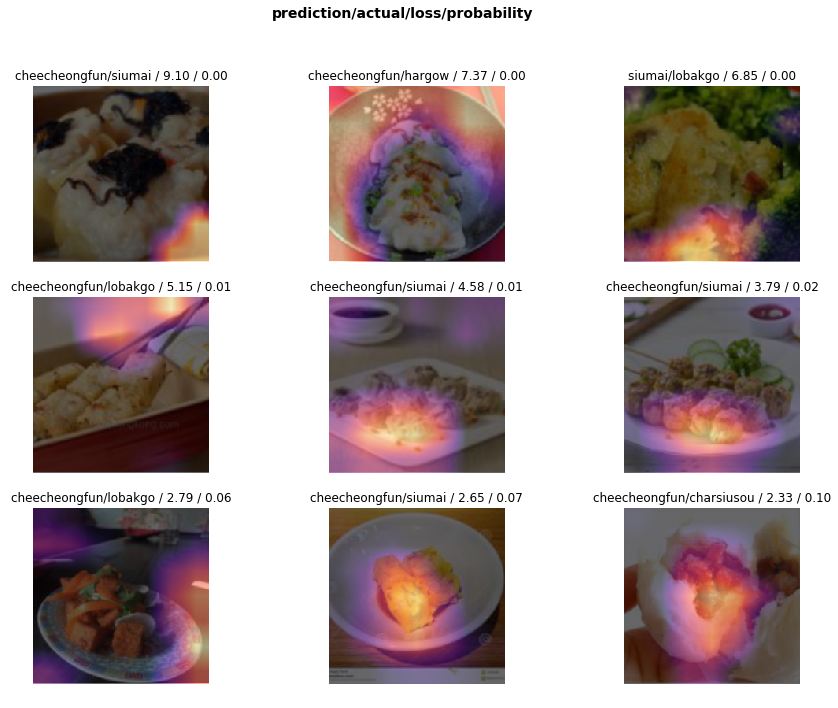

In [0]:
interpret_cleaned.plot_top_losses(9, figsize=(15,11))

## Training & finetuning with resnet-50

In [0]:
learn_cleaned50 = cnn_learner(data2, models.resnet50, metrics=error_rate)

In [0]:
learn_cleaned50.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.655776,1.074644,0.423729,00:07
1,1.060038,0.426286,0.144068,00:06
2,0.765334,0.462426,0.161017,00:06
3,0.602831,0.449330,0.144068,00:06
4,0.478973,0.428820,0.127119,00:06
5,0.397765,0.433457,0.118644,00:06
6,0.332555,0.437746,0.127119,00:06
7,0.288448,0.437288,0.135593,00:06
8,0.253740,0.432407,0.135593,00:06
9,0.220242,0.432829,0.135593,00:06


In [0]:
learn_cleaned50.unfreeze()

In [0]:
learn_cleaned50.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


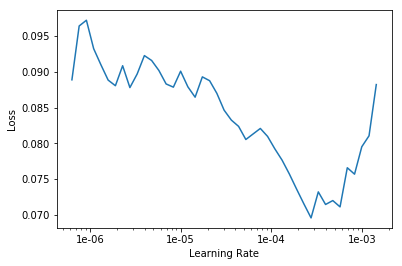

In [0]:
learn_cleaned50.recorder.plot()

In [0]:
learn_cleaned50.fit_one_cycle(5, max_lr=slice(1e-4, 5e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.109317,0.682296,0.169492,00:07
1,0.277890,2.939289,0.262712,00:07
2,0.331545,2.263224,0.245763,00:08
3,0.309646,0.597230,0.127119,00:08
4,0.264014,0.429430,0.127119,00:07


In [0]:
learn_cleaned50.export('export.pkl')

In [0]:
interpret_cleaned50 = ClassificationInterpretation.from_learner(learn_cleaned50)

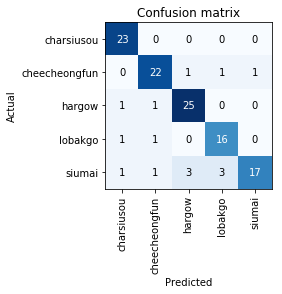

In [0]:
interpret_cleaned50.plot_confusion_matrix()

In [0]:
interpret_cleaned50.most_confused()

[('siumai', 'hargow', 3),
 ('siumai', 'lobakgo', 3),
 ('cheecheongfun', 'hargow', 1),
 ('cheecheongfun', 'lobakgo', 1),
 ('cheecheongfun', 'siumai', 1),
 ('hargow', 'charsiusou', 1),
 ('hargow', 'cheecheongfun', 1),
 ('lobakgo', 'charsiusou', 1),
 ('lobakgo', 'cheecheongfun', 1),
 ('siumai', 'charsiusou', 1),
 ('siumai', 'cheecheongfun', 1)]